
## **Libraries**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

## **Data Exploration**

In [2]:
df = pd.read_csv("customer_segmentation_data.csv",index_col = False)

# Display the first few rows
print(df.head())


   minutes_watched     CLV  region  channel
0           3197.0  205.42       2        4
1             63.0  149.99       0        1
2            605.0  119.00       2        2
3             20.0  240.00       2        4
4            245.0  184.36       1        4


In [3]:
df.shape

(3834, 4)

In [4]:
df.describe()

,minutes_watched,CLV,region,channel
count,3725.000000,3834.000000,3834.000000,3834.000000
mean,1972.094497,118.383920,1.167188,3.870370
std,7401.693028,70.471274,0.923055,2.191972
min,0.000000,0.000000,0.000000,1.000000
25%,159.000000,62.580000,0.000000,2.000000
50%,512.000000,119.000000,2.000000,3.000000
75%,1521.000000,149.990000,2.000000,6.000000
max,288508.000000,626.400000,2.000000,8.000000


In [5]:
df.isna().sum()

,0
minutes_watched,109
CLV,0
region,0
channel,0


In [6]:
## fill null with zeros --> as these customers have just registered for the program but have not watched anything
df['minutes_watched'] = df['minutes_watched'].fillna(0)

In [7]:
df['region'].value_counts()

,count
region,
2,2007
0,1366
1,461


In [8]:
df['channel'].value_counts()

,count
channel,
3,1094
1,671
4,650
7,478
2,306
6,289
8,288
5,58


In [9]:
df.dtypes

,0
minutes_watched,float64
CLV,float64
region,int64
channel,int64


## **Data Visualisation & Correlation Analysis**

In [10]:
df.corr()

,minutes_watched,CLV,region,channel
minutes_watched,1.000000,0.114153,0.040100,-0.003718
CLV,0.114153,1.000000,-0.273312,-0.026359
region,0.040100,-0.273312,1.000000,0.015098
channel,-0.003718,-0.026359,0.015098,1.000000


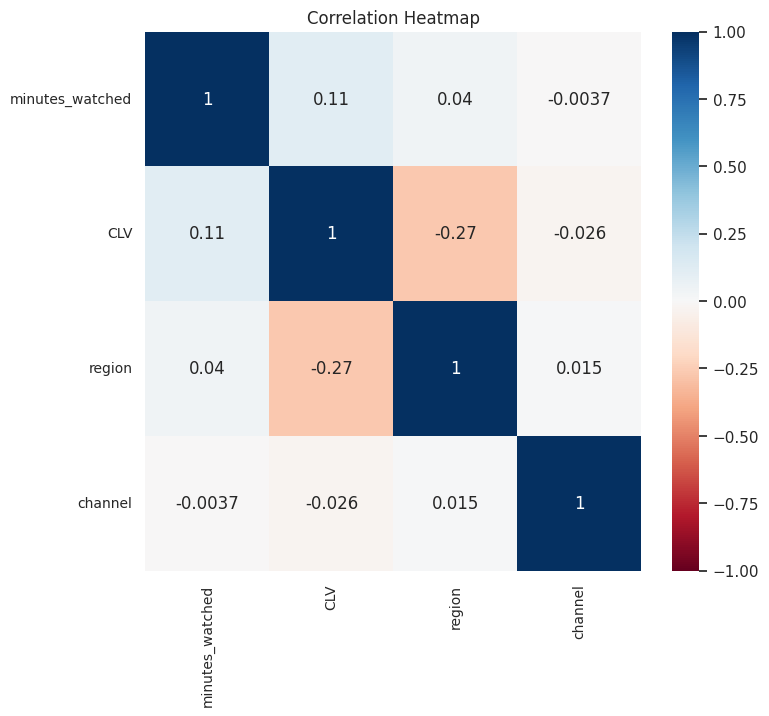

In [11]:
### plotting the above correlation
plt.figure(figsize = (8, 7))
s = sns.heatmap(df.corr(),
               annot = True,
               cmap = 'RdBu',
               vmin = -1,
               vmax = 1)
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 10)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 10)
plt.title('Correlation Heatmap')
plt.savefig('corr.png')
plt.show()

This analysis does not uncover significant or positive correlations in the data. To better understand the relationships within the data, need to apply more advanced learning techniques.

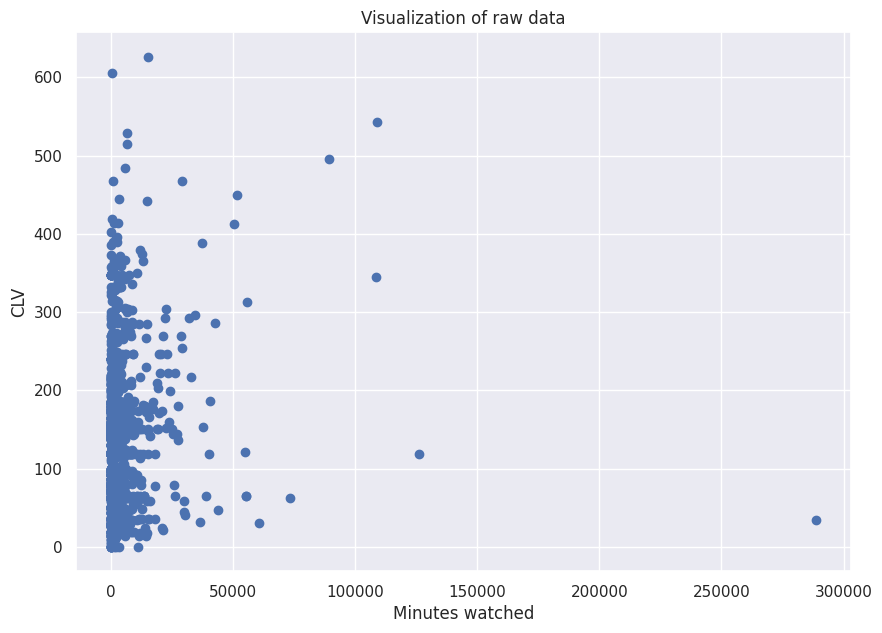

In [12]:
plt.figure(figsize = (10, 7))
plt.scatter(df.iloc[:, 0], df.iloc[:, 1])
plt.xlabel('Minutes watched')
plt.ylabel('CLV')
plt.title('Visualization of raw data')
plt.savefig("scatter_minsWatched.png")
plt.show()

Visualizing minutes watched against CLV reveals little insight. Apart from a few outliers, the chart appears cluttered due to the vast difference in scale between minutes watched and CLV.

In [13]:
## now converting minutes_watched to hours_watched, and then plotting the above graph again
df['hours_watched'] = df['minutes_watched'].apply(lambda x: round(x/(60),0) )
df.head()

,minutes_watched,CLV,region,channel,hours_watched
0,3197.0,205.42,2,4,53.0
1,63.0,149.99,0,1,1.0
2,605.0,119.00,2,2,10.0
3,20.0,240.00,2,4,0.0
4,245.0,184.36,1,4,4.0


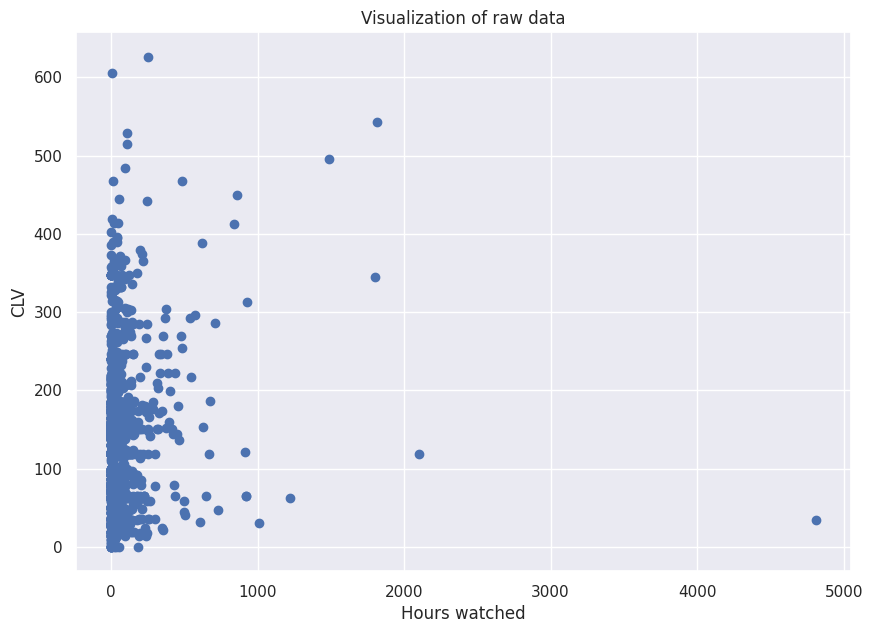

In [14]:
plt.figure(figsize = (10, 7))
plt.scatter(df.iloc[:, -1], df.iloc[:, 1])
plt.xlabel('Hours watched')
plt.ylabel('CLV')
plt.title('Visualization of raw data')
plt.savefig("scatter.png")
plt.show()

Visualizing hours watched against CLV reveals little insight too. Apart from a few outliers, the chart appears cluttered due to the vast difference in scale between hours watched and CLV.

In [15]:
df = df[['minutes_watched', 'CLV', 'region', 'channel']]

### **Create Dummy Variables**

In [16]:
# create a list of the channels of acquisition variable
df_heard_from = df['channel']
# create a list of the channels of the country variable
df_countries = df['region']

In [17]:
# identical dummies for the channel of aquisition
segment_dummies = pd.get_dummies(df_heard_from, prefix = 'channel', prefix_sep = '_')
segment_dummies = segment_dummies.groupby(level=0).sum()
segment_dummies.head()

,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,channel_8
0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0,0


In [18]:
df = pd.concat([df, segment_dummies], axis = 1)
df.head()

,minutes_watched,CLV,region,channel,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,channel_8
0,3197.0,205.42,2,4,0,0,0,1,0,0,0,0
1,63.0,149.99,0,1,1,0,0,0,0,0,0,0
2,605.0,119.00,2,2,0,1,0,0,0,0,0,0
3,20.0,240.00,2,4,0,0,0,1,0,0,0,0
4,245.0,184.36,1,4,0,0,0,1,0,0,0,0


In [19]:
# Creating dummy variables for the `df_countries` dataframe.
# Each column in `df_countries` will be prefixed with 'country_region_' in the new columns.
segment_dummies_2 = pd.get_dummies(df_countries, prefix = 'country_region', prefix_sep = '_')
segment_dummies_2 = segment_dummies_2.groupby(level=0).sum()

# Appending the created dummy columns from `segment_dummies_2` to the `df` dataframe.
df = pd.concat([df, segment_dummies_2], axis = 1)
df.head()

,minutes_watched,CLV,region,channel,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,channel_8,country_region_0,country_region_1,country_region_2
0,3197.0,205.42,2,4,0,0,0,1,0,0,0,0,0,0,1
1,63.0,149.99,0,1,1,0,0,0,0,0,0,0,1,0,0
2,605.0,119.00,2,2,0,1,0,0,0,0,0,0,0,0,1
3,20.0,240.00,2,4,0,0,0,1,0,0,0,0,0,0,1
4,245.0,184.36,1,4,0,0,0,1,0,0,0,0,0,1,0


In [20]:
# drop the channel,region variable as it is non-numerical and we'll not be able to perform the segmentation
df = df.drop(["channel",'region'], axis = 1)
df.head()

,minutes_watched,CLV,channel_1,channel_2,channel_3,channel_4,channel_5,channel_6,channel_7,channel_8,country_region_0,country_region_1,country_region_2
0,3197.0,205.42,0,0,0,1,0,0,0,0,0,0,1
1,63.0,149.99,1,0,0,0,0,0,0,0,1,0,0
2,605.0,119.00,0,1,0,0,0,0,0,0,0,0,1
3,20.0,240.00,0,0,0,1,0,0,0,0,0,0,1
4,245.0,184.36,0,0,0,1,0,0,0,0,0,1,0


In [21]:
# rename the columns after adding the dummie variables
df = df.rename(columns = {'channel_1':'Google', 'channel_2':'Facebook', 'channel_3':'YouTube','channel_4':'LinkedIn',
                                                    'channel_5':'Twitter', 'channel_6':'Instagram', 'channel_7':'Friend', 'channel_8':'Other',
                                                    'country_region_0':'Region_0','country_region_1':'Region_1','country_region_2':'Region_2'})


In [22]:
df

,minutes_watched,CLV,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other,Region_0,Region_1,Region_2
0,3197.0,205.42,0,0,0,1,0,0,0,0,0,0,1
1,63.0,149.99,1,0,0,0,0,0,0,0,1,0,0
2,605.0,119.00,0,1,0,0,0,0,0,0,0,0,1
3,20.0,240.00,0,0,0,1,0,0,0,0,0,0,1
4,245.0,184.36,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3829,11.0,79.00,0,0,1,0,0,0,0,0,1,0,0
3830,28.0,79.00,0,1,0,0,0,0,0,0,1,0,0
3831,57.0,36.00,0,1,0,0,0,0,0,0,0,0,1
3832,44.0,36.00,1,0,0,0,0,0,0,0,0,0,1


## **Model Implementation**

In [23]:
from sklearn.preprocessing import StandardScaler

In [24]:
## So before implementing the model, we must standardise the data -  considering such a difference in magnitude regarding minutes watched versus CLV, as we saw in the scatter plot.
## Without standardization, features with larger ranges will dominate distance calculations, skewing clustering results.
## Data Standardization: standardizes data by removing the mean and scaling it to unit variance for each feature (column).

scaler = StandardScaler()
df_std = scaler.fit_transform(df)

In [25]:
df_std

array([[ 0.17542513,  1.23521866, -0.46058699, ..., -0.74396546,
        -0.36969391,  0.95410372],
       [-0.25376647,  0.44855443,  2.17114254, ...,  1.34414843,
        -0.36969391, -1.04810408],
       [-0.17954125,  0.00874342, -0.46058699, ..., -0.74396546,
        -0.36969391,  0.95410372],
       ...,
       [-0.25458815, -1.16919507, -0.46058699, ..., -0.74396546,
        -0.36969391,  0.95410372],
       [-0.25636846, -1.16919507,  2.17114254, ..., -0.74396546,
        -0.36969391,  0.95410372],
       [-0.26239413, -0.55893778, -0.46058699, ...,  1.34414843,
        -0.36969391, -1.04810408]])

In [26]:
len(df_std)

3834

### **Hierarchical Clustering**

In [27]:
hier_clust = linkage(df_std, method = 'ward')

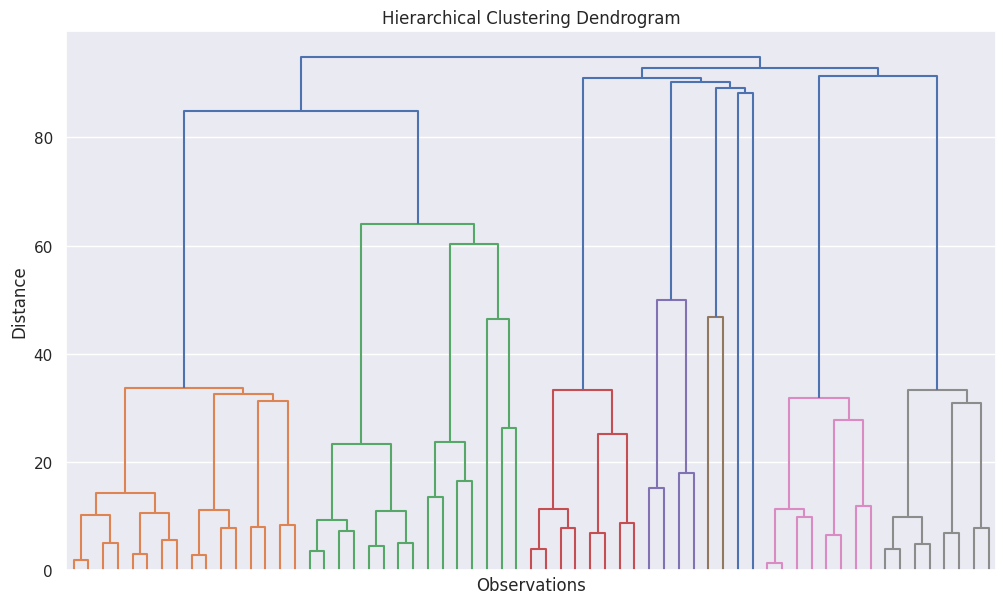

In [28]:
plt.figure(figsize = (12,7))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Distance')
dendrogram(hier_clust,
           truncate_mode = 'level',
           p = 5,
           show_leaf_counts = False,
           no_labels = True)
plt.savefig('hierarchical.png')
plt.show()





*   Cutting at Y = 60 results in 7 distinct clusters.
*   Large vertical gaps in the dendrogram indicate well-separated clusters, with higher merges (Y > 80) showing more dissimilar groups.
*   Smaller clusters at lower distances (e.g., Y < 20) are more homogeneous, while larger ones at higher distances represent broader groupings.
*   No obvious outliers are present, but the final merge at Y > 80 highlights distinct group differences.



### **K-means Clustering**

In [29]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(df_std)
    wcss.append(kmeans.inertia_)

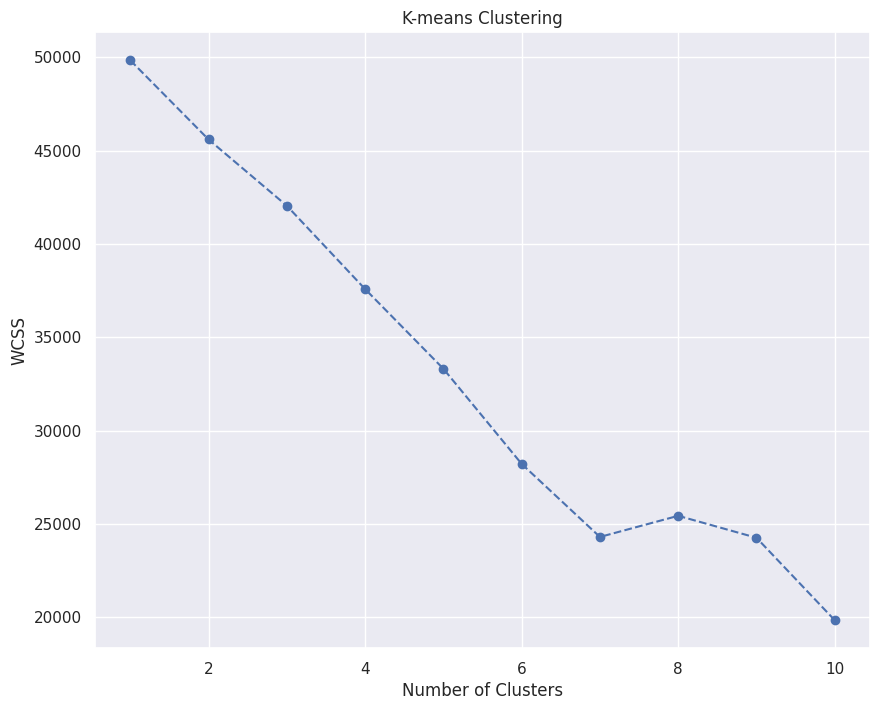

In [30]:
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.savefig('line_chart.png')
plt.show()



*   The elbow point is visible around 6 or 7 clusters, where the WCSS starts to flatten, indicating the optimal number of clusters.
*   The plot suggests that the clusters are compact and well-formed up to 7 clusters, after which additional clusters may overfit or add complexity without much benefit.


In [31]:
# the KMeans algorithm is initialized here with 7 clusters.
kmeans = KMeans(n_clusters = 7, init = 'k-means++', random_state = 42)

In [32]:
# Fitting the standardized data to the KMeans algorithm with 7 clusters.
kmeans.fit(df_std)

KMeans(n_clusters=7, random_state=42)

## **Model Interpretation**

In [33]:
df_kmeans = df.copy()

In [34]:
#assigns cluster labels generated by the K-Means algorithm to a new column in the DataFrame df_kmeans.
df_kmeans['Segment'] = kmeans.labels_

In [35]:
df_kmeans.head()

,minutes_watched,CLV,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other,Region_0,Region_1,Region_2,Segment
0,3197.0,205.42,0,0,0,1,0,0,0,0,0,0,1,3
1,63.0,149.99,1,0,0,0,0,0,0,0,1,0,0,5
2,605.0,119.00,0,1,0,0,0,0,0,0,0,0,1,0
3,20.0,240.00,0,0,0,1,0,0,0,0,0,0,1,3
4,245.0,184.36,0,0,0,1,0,0,0,0,0,1,0,3


In [36]:
df_kmeans['Segment'].value_counts()

,count
Segment,
5,940
1,883
3,650
2,478
0,306
4,289
6,288


In [37]:
df_segm_analysis = df_kmeans.groupby(['Segment']).mean()
df_segm_analysis

,minutes_watched,CLV,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other,Region_0,Region_1,Region_2
Segment,,,,,,,,,,,,,
0,2767.643791,108.260359,0.000000,1.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.287582,0.101307,0.611111
1,2203.057758,100.632299,0.369196,0.0,0.576444,0.0,0.054360,0.0,0.0,0.0,0.000000,0.003398,0.996602
2,2006.190377,113.654038,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0,0.257322,0.112971,0.629707
3,1589.376923,107.368708,0.000000,0.0,0.000000,1.0,0.000000,0.0,0.0,0.0,0.290769,0.107692,0.601538
4,1299.332180,115.180277,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.0,0.0,0.311419,0.190311,0.498270
5,1616.846809,147.889213,0.367021,0.0,0.622340,0.0,0.010638,0.0,0.0,0.0,0.774468,0.221277,0.004255
6,2314.083333,123.189965,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,1.0,0.513889,0.138889,0.347222


In [38]:
df_segm_analysis['N Obs'] = df_kmeans[['Segment','Region_0']].groupby(['Segment']).count()
df_segm_analysis['Prop Obs'] = (df_segm_analysis['N Obs'] / df_segm_analysis['N Obs'].sum())
df_segm_analysis

,minutes_watched,CLV,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other,Region_0,Region_1,Region_2,N Obs,Prop Obs
Segment,,,,,,,,,,,,,,,
0,2767.643791,108.260359,0.000000,1.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.287582,0.101307,0.611111,306,0.079812
1,2203.057758,100.632299,0.369196,0.0,0.576444,0.0,0.054360,0.0,0.0,0.0,0.000000,0.003398,0.996602,883,0.230308
2,2006.190377,113.654038,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0,0.257322,0.112971,0.629707,478,0.124674
3,1589.376923,107.368708,0.000000,0.0,0.000000,1.0,0.000000,0.0,0.0,0.0,0.290769,0.107692,0.601538,650,0.169536
4,1299.332180,115.180277,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.0,0.0,0.311419,0.190311,0.498270,289,0.075378
5,1616.846809,147.889213,0.367021,0.0,0.622340,0.0,0.010638,0.0,0.0,0.0,0.774468,0.221277,0.004255,940,0.245175
6,2314.083333,123.189965,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,1.0,0.513889,0.138889,0.347222,288,0.075117


In [39]:
df_segm_analysis.round(2)

,minutes_watched,CLV,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other,Region_0,Region_1,Region_2,N Obs,Prop Obs
Segment,,,,,,,,,,,,,,,
0,2767.64,108.26,0.00,1.0,0.00,0.0,0.00,0.0,0.0,0.0,0.29,0.10,0.61,306,0.08
1,2203.06,100.63,0.37,0.0,0.58,0.0,0.05,0.0,0.0,0.0,0.00,0.00,1.00,883,0.23
2,2006.19,113.65,0.00,0.0,0.00,0.0,0.00,0.0,1.0,0.0,0.26,0.11,0.63,478,0.12
3,1589.38,107.37,0.00,0.0,0.00,1.0,0.00,0.0,0.0,0.0,0.29,0.11,0.60,650,0.17
4,1299.33,115.18,0.00,0.0,0.00,0.0,0.00,1.0,0.0,0.0,0.31,0.19,0.50,289,0.08
5,1616.85,147.89,0.37,0.0,0.62,0.0,0.01,0.0,0.0,0.0,0.77,0.22,0.00,940,0.25
6,2314.08,123.19,0.00,0.0,0.00,0.0,0.00,0.0,0.0,1.0,0.51,0.14,0.35,288,0.08


Based on Segmentation Analysis, naming the clusters

In [40]:
# Renaming the index labels (which are segment numbers) with more descriptive names.
# This provides a more interpretable profile for each cluster.
df_segm_analysis.rename({0:'High-Engagement Facebook Users',
                         1:'Google & YouTube Learners with Low Spending',
                         2:'Referral Learners with Moderate Engagement',
                         3:'Moderate-Spending LinkedIn Users',
                         4:'Instagram Users with Low Engagement',
                         5:'High-Spending YouTube Users',
                         6:'Moderate-Spending Other Channel Users'
                        })


,minutes_watched,CLV,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other,Region_0,Region_1,Region_2,N Obs,Prop Obs
Segment,,,,,,,,,,,,,,,
High-Engagement Facebook Users,2767.643791,108.260359,0.000000,1.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.287582,0.101307,0.611111,306,0.079812
Google & YouTube Learners with Low Spending,2203.057758,100.632299,0.369196,0.0,0.576444,0.0,0.054360,0.0,0.0,0.0,0.000000,0.003398,0.996602,883,0.230308
Referral Learners with Moderate Engagement,2006.190377,113.654038,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0,0.257322,0.112971,0.629707,478,0.124674
Moderate-Spending LinkedIn Users,1589.376923,107.368708,0.000000,0.0,0.000000,1.0,0.000000,0.0,0.0,0.0,0.290769,0.107692,0.601538,650,0.169536
Instagram Users with Low Engagement,1299.332180,115.180277,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.0,0.0,0.311419,0.190311,0.498270,289,0.075378
High-Spending YouTube Users,1616.846809,147.889213,0.367021,0.0,0.622340,0.0,0.010638,0.0,0.0,0.0,0.774468,0.221277,0.004255,940,0.245175
Moderate-Spending Other Channel Users,2314.083333,123.189965,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,1.0,0.513889,0.138889,0.347222,288,0.075117


In [41]:
# Mapping the cluster numbers (Segment) to more human-readable labels using a dictionary.
# This helps in interpreting the clusters in plots and other visualizations.
df_kmeans['Labels'] = df_kmeans['Segment'].map({0:'High-Engagement Facebook Users',
                         1:'Google & YouTube Learners with Low Spending',
                         2:'Referral Learners with Moderate Engagement',
                         3:'Moderate-Spending LinkedIn Users',
                         4:'Instagram Users with Low Engagement',
                         5:'High-Spending YouTube Users',
                         6:'Moderate-Spending Other Channel Users'
                        })

In [42]:
df_kmeans

,minutes_watched,CLV,Google,Facebook,YouTube,LinkedIn,Twitter,Instagram,Friend,Other,Region_0,Region_1,Region_2,Segment,Labels
0,3197.0,205.42,0,0,0,1,0,0,0,0,0,0,1,3,Moderate-Spending LinkedIn Users
1,63.0,149.99,1,0,0,0,0,0,0,0,1,0,0,5,High-Spending YouTube Users
2,605.0,119.00,0,1,0,0,0,0,0,0,0,0,1,0,High-Engagement Facebook Users
3,20.0,240.00,0,0,0,1,0,0,0,0,0,0,1,3,Moderate-Spending LinkedIn Users
4,245.0,184.36,0,0,0,1,0,0,0,0,0,1,0,3,Moderate-Spending LinkedIn Users
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3829,11.0,79.00,0,0,1,0,0,0,0,0,1,0,0,5,High-Spending YouTube Users
3830,28.0,79.00,0,1,0,0,0,0,0,0,1,0,0,0,High-Engagement Facebook Users
3831,57.0,36.00,0,1,0,0,0,0,0,0,0,0,1,0,High-Engagement Facebook Users
3832,44.0,36.00,1,0,0,0,0,0,0,0,0,0,1,1,Google & YouTube Learners with Low Spending


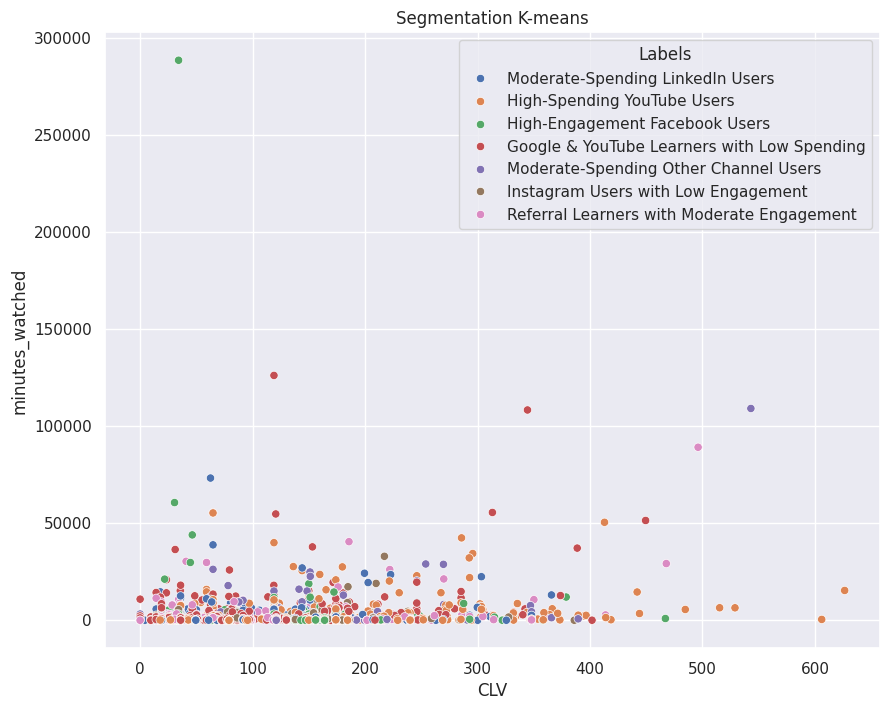

In [43]:
x_axis = df_kmeans['CLV']
y_axis = df_kmeans['minutes_watched']

# Setting the figure size for the scatter plot.
plt.figure(figsize = (10, 8))

# The 'hue' parameter colors the points based on the 'Labels' column, allowing for distinction between clusters.
sns.scatterplot(x = x_axis, y = y_axis, hue = df_kmeans['Labels'])

plt.title('Segmentation K-means')
plt.show()

Detailed findings in the ***findings.html*** file